In [1]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple
import time
import torch
import torch.utils.checkpoint
from packaging import version
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.nn import functional as F

from transformers.activations import ACT2FN
from transformers.file_utils import (
    ModelOutput,
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    replace_return_docstrings,
)
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
)
from transformers.modeling_utils import (
    PreTrainedModel,
    apply_chunking_to_forward,
    find_pruneable_heads_and_indices,
    prune_linear_layer,
)
from transformers.utils import logging
from transformers.models.bert.configuration_bert import BertConfig

logger = logging.get_logger(__name__)

class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        if version.parse(torch.__version__) > version.parse("1.6.0"):
            self.register_buffer(
                "token_type_ids",
                torch.zeros(self.position_ids.size(), dtype=torch.long),
                persistent=False,
            )

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

        # Setting the token_type_ids to the registered buffer in constructor where it is all zeros, which usually occurs
        # when its auto-generated, registered buffer helps users when tracing the model without passing token_type_ids, solves
        # issue #5664
        if token_type_ids is None:
            if hasattr(self, "token_type_ids"):
                buffered_token_type_ids = self.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

def lowdim_apply(linear : nn.Linear, input, mode:bool, factor:int, interpolate='avg'):
    #print('low_dim_apply', mode, factor, interpolate)
    if mode:
        if interpolate == 'avg':
            s = linear.weight.shape
            w = F.adaptive_avg_pool2d(linear.weight.view(1, 1, s[0], s[1]), output_size = (s[0] // factor, s[1] // factor)).view(s[0]//factor, s[1]//factor)
            s = linear.bias.shape
            b = F.adaptive_avg_pool1d(linear.bias.view(1,1,s[0]), (s[0] // factor,)).view(s[0]//factor)
        elif interpolate == 'max':
            s = linear.weight.shape
            w = F.adaptive_max_pool2d(linear.weight.view(1, 1, s[0], s[1]), output_size = (s[0] // factor, s[1] // factor)).view(s[0]//factor, s[1]//factor)
            s = linear.bias.shape
            b = F.adaptive_max_pool1d(linear.bias.view(1,1,s[0]), (s[0] // factor,)).view(s[0]//factor)
        elif interpolate == 'output_only':
            s = linear.weight.shape
            w = F.adaptive_max_pool2d(linear.weight.view(1, 1, s[0], s[1]), output_size = (s[0], s[1] // factor)).view(s[0], s[1]//factor)
            s = linear.bias.shape
            b = F.adaptive_max_pool1d(linear.bias.view(1,1,s[0]), (s[0] // factor,)).view(s[0]//factor)
        else:
            s = linear.weight.shape
            w = F.interpolate(
                linear.weight.view(1, 1, s[0], s[1]), 
                size = (s[0] // factor, s[1] // factor),
                mode = interpolate
            ).view(s[0]//factor, s[1]//factor)
            s = linear.bias.shape
            b = F.interpolate(
                linear.bias.view(1,1,s[0]), 
                size = (s[0] // factor,),
                mode = interpolate
            ).view(s[0]//factor)
        return F.linear(input, w, b)
    else:
        return linear(input)

class BertSelfAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        
        self.hidden_size = config.hidden_size
        self.lowdim = False
        self.lowdim_linear = False
        self.lowdim_qk_linear = True
        self.lowdim_qk = False
        self.lowdim_factor = 4
        self.lowdim_mode = 'avg'
        self.lowdim_qk_linear_mode = 'avg'

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder
        self.print = True
    
    def update_lowdim(self):
        def downsize_linear(linear):
            factor = self.lowdim_factor
            if self.lowdim_qk_linear_mode == 'avg':
                s = linear.weight.shape
                w = F.adaptive_avg_pool2d(linear.weight.view(1, 1, s[0], s[1]), output_size = (s[0] // factor, s[1])).view(s[0] // factor, s[1])
                s = linear.bias.shape
                b = F.adaptive_avg_pool1d(linear.bias.view(1,1,s[0]), (s[0] // factor,)).view(s[0]//factor)
            elif self.lowdim_qk_linear_mode == 'absmax':
                import numba
                @numba.njit
                def resize(x, factor):
                    # x (SIZE, N) -> (SIZE // factor, N)
                    SIZE, N = x.shape
                    ret = np.empty((SIZE // factor, N), dtype=x.dtype)
                    for i in range(N):
                        for j in range(SIZE // factor):
                            value = 0
                            for k in range(factor):
                                if abs(x[j*factor+k, i]) >= abs(value):
                                    value = x[j*factor+k, i]
                            ret[j, i] = value
                    return ret
                w = torch.tensor(resize(linear.weight.data.cpu().numpy(), factor))
                b = torch.tensor(resize(linear.bias.data.cpu().numpy().reshape(-1, 1), factor)).view(-1)
            else:
                raise Exception('no')
            l = nn.Linear(w.shape[1], w.shape[0])
            l = l.to(linear.weight.device)
            l.weight.data[:,:] = w
            l.bias.data[:] = b
            #print(linear.weight.shape, 'to', l.weight.shape)
            return l
        self.low_query = downsize_linear(self.query)
        self.low_key = downsize_linear(self.key)

    def resize_vector(self, x, use, factor=4):
        #print('resize_vec', use, factor)
        if not use: return x
        #return F.interpolate(x, (model.config.hidden_size // factor,))
        s = x.shape
        return F.adaptive_avg_pool1d(x.reshape(s[0]*s[1], s[2], s[3]), output_size = (s[-1] // factor, )).view(s[0],s[1],s[2],s[3]//factor)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, x.shape[-1] // self.num_attention_heads)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None, #removed
        encoder_hidden_states=None, #removed
        encoder_attention_mask=None, #removed
        past_key_value=None, #removed
        output_attentions=False,
    ):
        assert encoder_hidden_states is None and encoder_attention_mask is None and head_mask is None and past_key_value is None

        if self.is_decoder: raise Exception('removed')

        if self.print: 
            print('SelfAttention.forward: hidden_states, attention_mask backuped')
            self.last_hidden_states = hidden_states.clone().detach()
            self.last_attention_mask = attention_mask.clone().detach()
        if self.lowdim_qk_linear and self.lowdim:
            mixed_query_layer = self.low_query(hidden_states)
        else:
            mixed_query_layer = lowdim_apply(self.query, hidden_states, self.lowdim and self.lowdim_linear, self.lowdim_factor, self.lowdim_mode)

        is_cross_attention = encoder_hidden_states is not None
        if is_cross_attention and past_key_value is not None:
            raise Exception('oops')
        elif is_cross_attention:
            raise Exception('oops')
        elif past_key_value is not None:
            raise Exception('oops')
        else:
            if self.print: print('SelfAttention.forward: expected')
            if self.lowdim_qk_linear and self.lowdim:
                key_layer = self.transpose_for_scores(self.low_key(hidden_states))
            else:
                key_layer = self.resize_vector(
                    self.transpose_for_scores(
                        lowdim_apply(self.key, hidden_states, self.lowdim and self.lowdim_linear, self.lowdim_factor, self.lowdim_mode)
                    ),
                    self.lowdim and self.lowdim_qk,
                    self.lowdim_factor)
            value_layer = self.transpose_for_scores(
                lowdim_apply(self.value, hidden_states, self.lowdim and self.lowdim_linear, self.lowdim_factor, self.lowdim_mode))

        query_layer = self.resize_vector(
            self.transpose_for_scores(mixed_query_layer),
            self.lowdim and self.lowdim_qk, 
            self.lowdim_factor)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        #print(query_layer.shape, key_layer.transpose(-1, -2).shape)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            raise Exception('lowdim not applied')

        if self.lowdim: lowdim_factor = self.lowdim_factor
        else: lowdim_factor = 1
        
        attention_scores = attention_scores / math.sqrt(self.attention_head_size // lowdim_factor)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None: raise Exception()
        if self.print: 
            print('SelfAttention.forward: attention_probs.shape', attention_probs.shape)
            self.last_attention_probs = attention_probs.clone().detach()
            print('SelfAttention.forward: last_attention_probs is cloned from attention_probs')

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        if self.lowdim_linear: 
            new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size // lowdim_factor,)
        else: 
            new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
        
        return outputs


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        self.self = BertSelfAttention(config, position_embedding_type=position_embedding_type)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        print('prune_heads called')
        raise Exception('unknown function')
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        self_outputs = self.self(
            hidden_states,
            attention_mask,
            head_mask,
            encoder_hidden_states,
            encoder_attention_mask,
            past_key_value,
            output_attentions,
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = BertAttention(config)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            if not self.is_decoder:
                raise ValueError(f"{self} should be used as a decoder model if cross attention is added")
            self.crossattention = BertAttention(config, position_embedding_type="absolute")
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        if self.is_decoder: raise Exception('removed')
        
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            pass
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        return outputs

    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output


class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                raise Exception('removed')
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = BertConfig
    #load_tf_weights = load_tf_weights_in_bert
    base_model_prefix = "bert"
    supports_gradient_checkpointing = True
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, BertEncoder):
            module.gradient_checkpointing = value


class BertModel(BertPreTrainedModel):
    """

    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in [Attention is
    all you need](https://arxiv.org/abs/1706.03762) by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit,
    Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.

    To behave as an decoder the model needs to be initialized with the `is_decoder` argument of the configuration set
    to `True`. To be used in a Seq2Seq model, the model needs to initialized with both `is_decoder` argument and
    `add_cross_attention` set to `True`; an `encoder_hidden_states` is then expected as an input to the forward pass.
    """

    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )

In [2]:
from transformers import BertTokenizer
from transformers import BertModel as RealBertModel
hugging = 'google/bert_uncased_L-2_H-128_A-2'
hugging = 'bert-base-uncased'
model = BertModel.from_pretrained(hugging)
model.cuda()
model.eval()
real_model = RealBertModel.from_pretrained(hugging)
real_model.cuda()
real_model.eval()
tokenizer = BertTokenizer.from_pretrained(hugging)
text = ['[CLS]Hello, World! I love to play with transformers.', '[CLS]This is the batch.', '[CLS]I love cats']
tokenized_result = tokenizer(text, padding=True, return_tensors='pt')
tokenized_result.input_ids = tokenized_result.input_ids.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predic

In [3]:
model.encoder.layer[0].attention.self.lowdim = False
model(tokenized_result.input_ids, output_attentions=True)
att = model.encoder.layer[0].attention.self
hidden_states = att.last_hidden_states.clone().detach()
attention_mask = att.last_attention_mask.clone().detach()
hidden_states.shape
#att.query.weight.shape

SelfAttention.forward: hidden_states, attention_mask backuped
SelfAttention.forward: expected
SelfAttention.forward: attention_probs.shape torch.Size([3, 12, 14, 14])
SelfAttention.forward: last_attention_probs is cloned from attention_probs
SelfAttention.forward: hidden_states, attention_mask backuped
SelfAttention.forward: expected
SelfAttention.forward: attention_probs.shape torch.Size([3, 12, 14, 14])
SelfAttention.forward: last_attention_probs is cloned from attention_probs
SelfAttention.forward: hidden_states, attention_mask backuped
SelfAttention.forward: expected
SelfAttention.forward: attention_probs.shape torch.Size([3, 12, 14, 14])
SelfAttention.forward: last_attention_probs is cloned from attention_probs
SelfAttention.forward: hidden_states, attention_mask backuped
SelfAttention.forward: expected
SelfAttention.forward: attention_probs.shape torch.Size([3, 12, 14, 14])
SelfAttention.forward: last_attention_probs is cloned from attention_probs
SelfAttention.forward: hidden_st

torch.Size([3, 14, 768])

In [4]:
t = time.time()
normal_result = att.forward(
    hidden_states = hidden_states,
    attention_mask = attention_mask,
    output_attentions=True,
)
print(time.time() - t)
real_result = real_model.encoder.layer[0].attention.self.forward(
    hidden_states = hidden_states,
    attention_mask = attention_mask,
    output_attentions=True,
)

SelfAttention.forward: hidden_states, attention_mask backuped
SelfAttention.forward: expected
SelfAttention.forward: attention_probs.shape torch.Size([3, 12, 14, 14])
SelfAttention.forward: last_attention_probs is cloned from attention_probs
0.003365039825439453


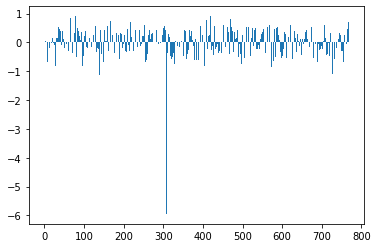

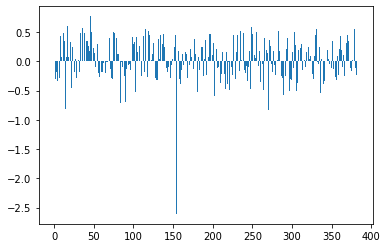

tensor(209.2968, device='cuda:0') tensor(52.4660, device='cuda:0')
tensor(190.6799, device='cuda:0') tensor(48.0566, device='cuda:0')
tensor(-8.6462, device='cuda:0') tensor(-2.0208, device='cuda:0')
tensor(52.1677, device='cuda:0') tensor(12.6805, device='cuda:0')
tensor(6.4235, device='cuda:0') tensor(0.6227, device='cuda:0')
tensor(6.1717, device='cuda:0') tensor(0.0492, device='cuda:0')
tensor(23.4705, device='cuda:0') tensor(5.1969, device='cuda:0')
tensor(3.9314, device='cuda:0') tensor(-2.7471, device='cuda:0')
tensor(38.7964, device='cuda:0') tensor(8.9564, device='cuda:0')
tensor(0.8757, device='cuda:0') tensor(-0.6088, device='cuda:0')
tensor(28.8300, device='cuda:0') tensor(5.6413, device='cuda:0')
tensor(6.4083, device='cuda:0') tensor(5.7907, device='cuda:0')
tensor(49.2122, device='cuda:0') tensor(10.4318, device='cuda:0')


In [5]:
import matplotlib.pyplot as plt
i = 12
a = hidden_states[0,i]
b_ = F.adaptive_avg_pool1d(hidden_states, output_size = (model.config.hidden_size // 2, ))
b = b_[0, i]
plt.bar(range(len(a)), a.cpu().numpy())
plt.show()
plt.bar(range(len(b)), b.cpu().numpy())
plt.show()
for k in range(13):
    print(torch.sum(hidden_states[0,0] * hidden_states[0,k]), torch.sum(b_[0,0] * b_[0,k]))

64
torch.Size([768, 768]) to torch.Size([384, 768])
torch.Size([768, 768]) to torch.Size([384, 768])
real


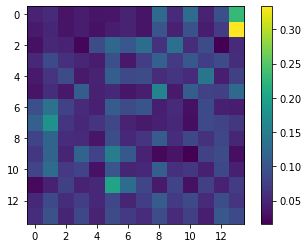

original


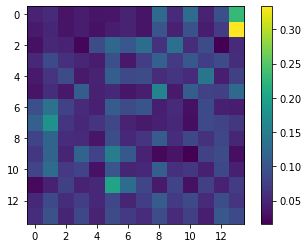

resize qk with abs max


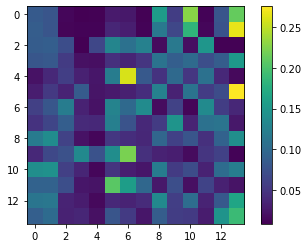

resize input + resize linear


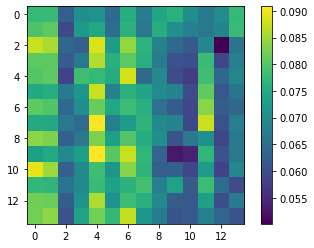

resize qk by linear


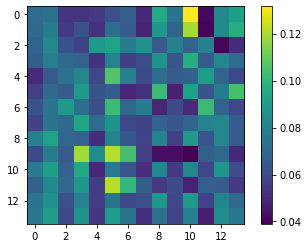

In [6]:
import matplotlib.pyplot as plt
import numpy as np
print(att.attention_head_size)

FACTOR = 2

att.lowdim = False
att.lowdim_factor = FACTOR
att.update_lowdim()

def downsize_linear(linear):
    factor = FACTOR
    s = linear.weight.shape
    w = F.adaptive_avg_pool2d(linear.weight.view(1, 1, s[0], s[1]), output_size = (s[0] // factor, s[1])).view(s[0] // factor, s[1])
    s = linear.bias.shape
    b = F.adaptive_avg_pool1d(linear.bias.view(1,1,s[0]), (s[0] // factor,)).view(s[0]//factor)
    l = nn.Linear(w.shape[1], w.shape[0])
    l = l.to(w.device)
    l.weight = nn.Parameter(w)
    l.bias = nn.Parameter(b)
    print(linear.weight.shape, 'to', l.weight.shape)
    return l

low_key = downsize_linear(att.key)
low_query = downsize_linear(att.query)

def _pool2(x):
    a = torch.empty_like(x)
    a = a[:a.shape[0]//2]
    for i in range(len(a)):
        if abs(x[i*2].item()) > abs(x[i*2+1]):
            a[i] = x[i*2]
        else:
            a[i] = x[i*2+1]
    return a

def pool2(x):
    s = x.shape
    x = x.reshape(-1, s[-1])
    a = torch.empty((x.shape[0], x.shape[1] // 2), device=x.device)
    for i in range(x.shape[0]):
        a[i,:] = _pool2(x[i])
    a = a.view(*(s[:-1]+(s[-1]//2,)))
    return a

def resize(x, factor=FACTOR, method='absmax'):
    if method == 'nearest':
        return F.interpolate(x, (model.config.hidden_size // factor,))
    elif method == 'avg':
        return F.adaptive_avg_pool1d(x, output_size = (x.shape[-1] // FACTOR, ))
    elif method == 'max':
        return F.adaptive_max_pool1d(x, output_size = (x.shape[-1] // FACTOR, ))
    elif method == 'absmax':
        if factor == 2:
            return pool2(x)
        elif factor == 4:
            return pool2(pool2(x))

i = 0
N = tokenized_result.input_ids.shape[1]
C = 64

a_k = att.key(hidden_states)[:,:,i*C:i*C+C]
a_q = att.query(hidden_states)[:,:,i*C:i*C+C]

b_k = lowdim_apply(att.key, resize(hidden_states), True, FACTOR, 'avg')[:,:,(64//FACTOR)*i:(64//FACTOR)*i+64//FACTOR]
b_q = lowdim_apply(att.query, resize(hidden_states), True, FACTOR, 'avg')[:,:,(64//FACTOR)*i:(64//FACTOR)*i+64//FACTOR]

d_k = low_key(hidden_states)[:,:,(64//FACTOR)*i:(64//FACTOR)*i+64//FACTOR]
d_q = low_query(hidden_states)[:,:,(64//FACTOR)*i:(64//FACTOR)*i+64//FACTOR]

a = torch.zeros((N,N), dtype=torch.float32)
b = torch.zeros((N,N), dtype=torch.float32)
c = torch.zeros((N,N), dtype=torch.float32)
d = torch.zeros((N,N), dtype=torch.float32)
for j in range(N):
    for k in range(N):
        a[k, j] = torch.sum(a_k[0,j] * a_q[0,k]).item() / math.sqrt(att.attention_head_size)
        b[k, j] = torch.sum(b_k[0,j] * b_q[0,k]).item() / \
            math.sqrt(att.attention_head_size // FACTOR)
        c[k, j] = torch.sum(resize(a_k[0,j].view(1,1,-1)) * resize(a_q[0,k].view(1,1,-1))).item() / \
            math.sqrt(att.attention_head_size // FACTOR)
        d[k, j] = torch.sum(d_k[0,j] * d_q[0,k]).item() / \
            math.sqrt(att.attention_head_size // FACTOR)

a = a + attention_mask.cpu()[0,i]
a = torch.nn.functional.softmax(a, dim=-1)
b = b + attention_mask.cpu()[0,i]
b = torch.nn.functional.softmax(b, dim=-1)
c = c + attention_mask.cpu()[0,i]
c = torch.nn.functional.softmax(c, dim=-1)
d = d + attention_mask.cpu()[0,i]
d = torch.nn.functional.softmax(d, dim=-1)

print('real')
plt.imshow(real_model.encoder.layer[0].attention.self.forward(
    hidden_states,
    attention_mask = attention_mask,
    output_attentions = True,
)[1].detach().cpu().numpy()[0,i,:,:])    #original
plt.colorbar()
plt.show()

print('original')
plt.imshow(a.detach().numpy())  #original
plt.colorbar()
plt.show()

print('resize qk with abs max')
plt.imshow(c.detach().numpy())  #resize vector\
plt.colorbar()
plt.show()

print('resize input + resize linear')
plt.imshow(b.detach().numpy())  #resize linear + vector
plt.colorbar()
plt.show()

print('resize qk by linear')
plt.imshow(d.detach().numpy())  #resize linear + vector
plt.colorbar()
plt.show()

def plot_linear_resize(linear_method='avg', resize_method='avg'):
    print('linear', linear_method, 'input', resize_method, 'factor', FACTOR)

    b_k = lowdim_apply(att.key, resize(hidden_states, method=resize_method), True, FACTOR, linear_method)[:,:,(64//FACTOR)*i:(64//FACTOR)*i+64//FACTOR]
    b_q = lowdim_apply(att.query, resize(hidden_states, method=resize_method), True, FACTOR, linear_method)[:,:,(64//FACTOR)*i:(64//FACTOR)*i+64//FACTOR]
    b = torch.zeros((N,N), dtype=torch.float32)
    for j in range(N):
        for k in range(N):
            b[k, j] = torch.sum(b_k[0,j] * b_q[0,k]).item() / \
                math.sqrt(att.attention_head_size // FACTOR)
    b = b + attention_mask.cpu()[0,i]
    b = torch.nn.functional.softmax(b, dim=-1)

    print('resize input + resize linear')
    plt.imshow(b.detach().numpy())  #resize linear + vector
    plt.colorbar()
    plt.show()
# plot_linear_resize('avg', 'avg')
# plot_linear_resize('avg', 'max')
# plot_linear_resize('avg', 'nearest')
# plot_linear_resize('max', 'avg')
# plot_linear_resize('max', 'max')
# plot_linear_resize('max', 'nearest')
# plot_linear_resize('nearest', 'avg')
# plot_linear_resize('nearest', 'max')
# plot_linear_resize('nearest', 'nearest')

def plot_qk_resize(resize_method = 'avg'):
    print('resize attention input qk. method:', resize_method)
    a_k = att.key(hidden_states)[:,:,i*C:i*C+C]
    a_q = att.query(hidden_states)[:,:,i*C:i*C+C]
    c = torch.zeros((N,N), dtype=torch.float32)
    for j in range(N):
        for k in range(N):
            c[k, j] = torch.sum(resize(a_k[0,j].view(1,1,-1), method=resize_method) * resize(a_q[0,k].view(1,1,-1), method=resize_method)).item() / \
                math.sqrt(att.attention_head_size // FACTOR)
    c = c + attention_mask.cpu()[0,i]
    c = torch.nn.functional.softmax(c, dim=-1)
    print('resize qk with abs max')
    plt.imshow(c.detach().numpy())  #resize vector\
    plt.colorbar()
    plt.show()

# plot_qk_resize('avg')
# plot_qk_resize('max')
# plot_qk_resize('nearest')

# plot_linear_resize('avg', 'absmax')
# plot_linear_resize('max', 'absmax')
# plot_linear_resize('nearest', 'absmax')

# # plot_linear_resize('absmax', 'absmax')
# # plot_linear_resize('absmax', 'avg')
# # plot_linear_resize('absmax', 'max')
# # plot_linear_resize('absmax', 'nearest')

# plot_qk_resize('absmax')

In [7]:
att.value.weight.shape
import time

In [8]:
from torch.nn import functional as F
t = time.time()
att.lowdim = True
att.lowdim_linear = False
att.lowdim_qk = False
att.lowdim_qk_linear = True
att.lowdim_factor = 2
att.lowdim_mode = 'nearest_'
att.lowdim_qk_linear_mode = 'absmax'
att.update_lowdim()
lowdim_result = att.forward(
    hidden_states = hidden_states,
    attention_mask = attention_mask,
    output_attentions = True,
)
att.lowdim = False
print(time.time() - t)

SelfAttention.forward: hidden_states, attention_mask backuped
SelfAttention.forward: expected
SelfAttention.forward: attention_probs.shape torch.Size([3, 12, 14, 14])
SelfAttention.forward: last_attention_probs is cloned from attention_probs
1.029902696609497


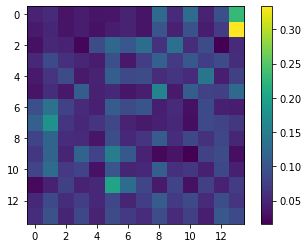

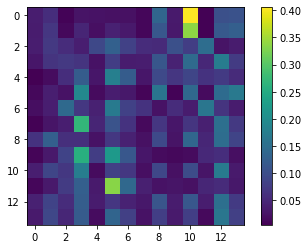

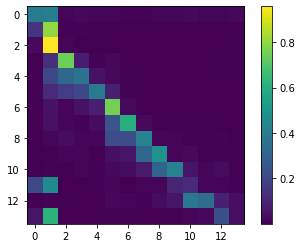

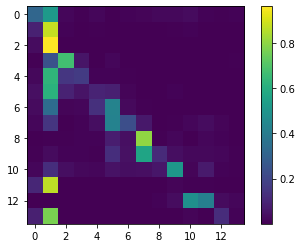

(torch.Size([3, 12, 14, 14]), torch.Size([3, 12, 14, 14]))

In [9]:
plt.imshow(normal_result[1][0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(lowdim_result[1][0,0].cpu().detach().numpy())
plt.colorbar()
plt.show()
# plt.imshow(real_result[1][0,0].cpu().detach().numpy())
# plt.colorbar()
# plt.show()
plt.imshow(normal_result[1][0,3].cpu().detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(lowdim_result[1][0,3].cpu().detach().numpy())
plt.colorbar()
plt.show()
normal_result[1].shape, lowdim_result[1].shape

In [10]:
model.config.num_attention_heads

12

In [11]:
normal_result[0].shape

torch.Size([3, 14, 768])

In [12]:
import tqdm
def set_print(model, v):
    for layer in model.encoder.layer:
        layer.attention.self.print = v
def set_lowdim(model, v, factor=2, qk_linear_mode='avg'):
    for layer in model.encoder.layer:
        if v != layer.attention.self.lowdim:
            if v:
                layer.attention.self.lowdim = True
                layer.attention.self.lowdim_linear = False
                layer.attention.self.lowdim_qk = False
                layer.attention.self.lowdim_qk_linear = True
                layer.attention.self.lowdim_factor = factor
                layer.attention.self.lowdim_qk_linear_mode = qk_linear_mode
                layer.attention.self.update_lowdim()
            else:
                layer.attention.self.lowdim = False
BATCH_SIZE=8
text = [
    ("[CLS]Bert Model with two heads on top as done during the pretraining: "+
    "a masked language modeling head and a next sentence prediction (classification) head."+
    "This model inherits from PreTrainedModel. Check the superclass documentation for the "+
    "generic methods the library implements for all its model (such as downloading or saving,"+
    " resizing the input embeddings, pruning heads etc.)"+
    "This model is also a PyTorch torch.nn.Module subclass. Use it as a regular PyTorch Module"+
    " and refer to the PyTorch documentation for all matter related to general usage and behavior.") * 4]*BATCH_SIZE

data = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
data = data.input_ids.cuda()
print(data.shape)

set_print(model, False)
set_lowdim(model, False)
model(data)
hidden = model.encoder.layer[0].attention.self.last_hidden_states
mask = model.encoder.layer[0].attention.self.last_attention_mask

N = 500
def run(model, tokens=512, factor=2, lowdim=False, using_amp=False, n=N):
    input = data[:, :tokens]
    set_lowdim(model, lowdim, factor=factor)
    from torch.cuda.amp import autocast
    model.eval()
    t = time.time()
    for k in tqdm.tqdm(range(n)):
        with torch.no_grad(), autocast(enabled=using_amp):
            model(input)
            # for i in range(len(model.encoder.layer)):
            #     model.encoder.layer[i].attention.self.forward(
            #         hidden_states = hidden,
            #         attention_mask = mask,
            #         output_attentions = True,
            #     )
    took = time.time() - t
    set_lowdim(model, False, factor=factor)
    return took

def exam(factor=2, using_amp=False):
    tokens = [64, 128, 256, 512]
    speedups = []
    for t in tokens:
        print(factor, using_amp, t)
        non = run(model, tokens=t, factor=factor, lowdim=False, using_amp=using_amp, n=20)
        non = run(model, tokens=t, factor=factor, lowdim=False, using_amp=using_amp)
        low = run(model, tokens=t, factor=factor, lowdim=True, using_amp=using_amp, n=20)
        low = run(model, tokens=t, factor=factor, lowdim=True, using_amp=using_amp)
        speedups.append(non / low)
    print('exam: factor', factor, 'amp', using_amp)
    plt.plot(tokens, speedups)
    #plt.axis('equal')
    plt.grid()
    plt.show()

# exam(2, False)
# exam(2, True)
# exam(4, False)
# exam(4, True)
exam(8, False)
exam(8, True)
exam(16, False)
exam(16, True)
exam(32, False)
exam(32, True)
print('done')

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([8, 512])
8 False 64


 29%|██▉       | 147/500 [00:09<00:21, 16.16it/s]


KeyboardInterrupt: 

In [ ]:
from trainer.classification import Trainer
trainer = Trainer()
trainer.load()
bert = trainer.model.bert
fc = trainer.model.classifier

100%|██████████| 7600/7600 [00:00<00:00, 58016.52it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert
Trainer.load: Loading...


In [ ]:
lowbert = BertModel.from_pretrained(trainer.model.bert_model_name)
lowbert = lowbert.to(trainer.device)
lowbert.eval()
lowbert.load_state_dict(bert.state_dict())
set_print(lowbert, False)

batch = trainer.get_batch()

def eval(model, batch=batch, fc=fc):
    for _ in range(1):
        lm_output = model(
            input_ids = batch.input_ids, 
            attention_mask = batch.attention_masks, 
            output_hidden_states=True,
            output_attentions=True,
        )
        last_hidden = lm_output.last_hidden_state[:,0,:]
        x = fc(last_hidden)
    return torch.argmax(x, dim=-1), batch.labels

t = time.time()
print(eval(bert))
print(time.time()-t)
t = time.time()
print(eval(lowbert))
print(time.time()-t)

set_lowdim(lowbert, True, factor=16)
t = time.time()
print(eval(lowbert))
print(time.time()-t)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(tensor([1, 2, 4, 1, 3, 4, 3, 3, 3, 2, 1, 1, 1, 4, 4, 2, 3, 3, 3, 4, 1, 3, 2, 3,
        2, 3, 4, 4, 4, 2, 1, 4, 1, 4, 4, 2, 2, 1, 1, 2, 4, 1, 4, 3, 4, 2, 2, 3,
        4, 4, 2, 1, 1, 2, 2, 3, 4, 2, 3, 4, 3, 4, 3, 1], device='cuda:0'), tensor([1, 2, 4, 1, 3, 4, 3, 3, 3, 2, 1, 1, 1, 4, 4, 2, 3, 3, 3, 4, 1, 3, 2, 3,
        2, 3, 4, 1, 4, 2, 1, 4, 1, 4, 4, 2, 2, 1, 1, 2, 4, 1, 4, 3, 4, 2, 2, 3,
        4, 4, 2, 1, 1, 2, 2, 3, 4, 2, 3, 4, 3, 4, 3, 1], device='cuda:0'))
0.3320026397705078
(tensor([1, 2, 4, 1, 3, 4, 3, 3, 3, 2, 1, 1, 1, 4, 4, 2, 3, 3, 3, 4, 1, 3, 2, 3,
        2, 3, 4, 4, 4, 2, 1, 4, 1, 4, 4, 2, 2, 1, 1, 2, 4, 1, 4, 3, 4, 2, 2, 3,
        4, 4, 2, 1, 1, 2, 2, 3, 4, 2, 3, 4, 3, 4, 3, 1], device='cuda:0'), tensor([1, 2, 4, 1, 3, 4, 3, 3, 3, 2, 1, 1, 1, 4, 4, 2, 3, 3, 3, 4, 1, 3, 2, 3,
        2, 3, 4, 1, 4, 2, 1, 4, 1, 4, 4, 2, 2, 1, 1, 2, 4, 1, 4, 3, 4, 2, 2, 3,
        4, 4, 2, 1, 1, 2, 2, 3, 4, 2, 3, 4, 3, 4, 3, 1], device='cuda:0'))
0.03699970245361328
(tensor([1, 2, 4, 1

In [ ]:
def accuracy(model, N=500, fc=fc):
    trainer.seed()
    acc = 0
    took = 0
    for _ in tqdm.tqdm(range(N)):
        batch = trainer.get_batch(test=True)
        with torch.no_grad():
            t = time.time()
            output, label = eval(model, batch=batch, fc=fc)
            took += time.time() - t
            acc += torch.mean((output == label) * 1.0).item()
    return acc/N, took

accuracy(bert, N=10)
print(accuracy(bert))

set_lowdim(lowbert, True, factor=16)
accuracy(lowbert, N=10)
print(accuracy(lowbert))

  0%|          | 0/500 [00:00<?, ?it/s]

(0.93428125, 2.3367702960968018)


100%|██████████| 500/500 [00:08<00:00, 60.67it/s]

(0.8609375, 2.321326971054077)


In [ ]:
trainer.model.bert = lowbert
trainer.model.train()
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=5e-5)
steps = 0
while steps < 2000:
    batch = trainer.get_batch()
    trainer.optimize_step(batch)
    if steps % 15 == 0: trainer.report(batch)
    steps += 1
    trainer.steps = steps
trainer.model.eval()
acc, took = accuracy(lowbert)

[5625] loss:0.46360746026039124, acc:0.90625, test_loss:0.3110387921333313, test_acc:0.890625
[15] loss:0.29329419136047363, acc:0.875, test_loss:0.2374582439661026, test_acc:0.9375
[30] loss:0.2513085603713989, acc:0.921875, test_loss:0.1530284881591797, test_acc:0.96875
[45] loss:0.3470487892627716, acc:0.90625, test_loss:0.32501739263534546, test_acc:0.890625
[60] loss:0.07794637978076935, acc:0.96875, test_loss:0.27406245470046997, test_acc:0.875
[75] loss:0.33097997307777405, acc:0.921875, test_loss:0.275108277797699, test_acc:0.9375


KeyboardInterrupt: 

100%|██████████| 7600/7600 [00:00<00:00, 211066.30it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert
Trainer.load: Loading...


100%|██████████| 500/500 [00:09<00:00, 55.31it/s]
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 500/500 [00:08<00:00, 58.70it/s]
Some we

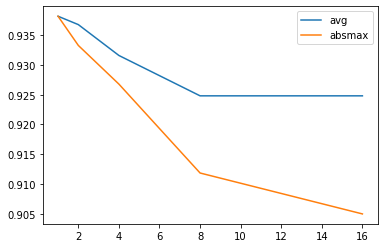

In [ ]:
trainer = Trainer()
trainer.load()
trainer.model.eval()
bert = trainer.model.bert
fc = trainer.model.classifier
acc_bert = accuracy(bert)[0]
for interp_mode in ['avg', 'absmax']:
    accs = [acc_bert]
    for factor in [2, 4, 8, 16]:
        lowbert = BertModel.from_pretrained(trainer.model.bert_model_name)
        lowbert.to(trainer.device)
        lowbert.train()
        lowbert.load_state_dict(bert.state_dict())
        set_print(lowbert, False)
        set_lowdim(lowbert, True, factor=factor, qk_linear_mode=interp_mode)

        trainer.model.bert = lowbert
        trainer.model.train()
        trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=5e-5)
        trainer.scaler = torch.cuda.amp.GradScaler()
        for steps in tqdm.tqdm(range(1000)):
            batch = trainer.get_batch()
            trainer.optimize_step(batch)
            #if steps % 15 == 0: trainer.report(batch)
            trainer.steps = steps
        trainer.model.eval()
        acc, took = accuracy(lowbert)
        accs.append(acc)
    plt.plot([1, 2, 4, 8, 16],accs, label=interp_mode)
plt.legend()
plt.show()

100%|██████████| 7600/7600 [00:00<00:00, 199999.44it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000
Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert
Trainer.load: Loading...


100%|██████████| 500/500 [00:08<00:00, 55.64it/s]
Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 500/500 [00:08<00:00, 57.40it/s]
Some we

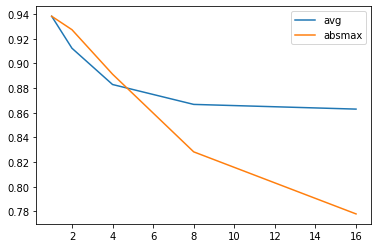

In [ ]:
trainer = Trainer()
trainer.load()
trainer.model.eval()
bert = trainer.model.bert
fc = trainer.model.classifier
acc_bert = accuracy(bert)[0]
for interp_mode in ['avg', 'absmax']:
    accs = [acc_bert]
    for factor in [2, 4, 8, 16]:
        lowbert = BertModel.from_pretrained(trainer.model.bert_model_name)
        lowbert.to(trainer.device)
        lowbert.train()
        lowbert.load_state_dict(bert.state_dict())
        set_print(lowbert, False)
        set_lowdim(lowbert, True, factor=factor, qk_linear_mode=interp_mode)

        trainer.model.bert = lowbert
        trainer.model.train()
        trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=5e-5)
        trainer.scaler = torch.cuda.amp.GradScaler()
        steps = 0
        # while steps < 1000:
        #     batch = trainer.get_batch()
        #     trainer.optimize_step(batch)
        #     if steps % 15 == 0: trainer.report(batch)
        #     steps += 1
        #     trainer.steps = steps
        trainer.model.eval()
        acc, took = accuracy(lowbert)
        accs.append(acc)
    plt.plot([1,2,4,8,16], accs, label=interp_mode)
plt.legend()
plt.show()

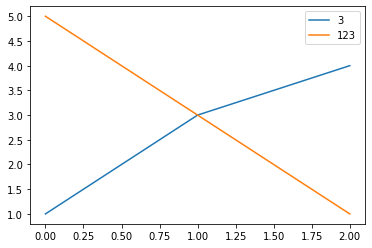

In [ ]:
plt.plot([1,3,4], label='3')
plt.plot([5,3,1], label='123')
plt.legend()

In [ ]:
accs[2]

0.89121875